In [13]:
pip install torch==2.0.0 torchvision==0.15.1

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install d2l==1.0.3

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd

data = pd.read_csv('METLIN_CCS_vectorfingerprintsVectorized.csv', nrows = 5)
print(data)

adducts = data.iloc[:, 10]

                                       Molecule Name Molecular Formula  \
0  3-[3-(2,3-dihydroindol-1-yl)propyl]-1-[(4-fluo...        C19H22FN3O   
1  3-{[1,1'-biphenyl]-4-ylmethylidene}-6-fluoro-2...        C22H15FO3S   
2  1-{[3-(4-methoxyphenyl)-1,2,4-oxadiazol-5-yl]m...        C25H28N4O3   
3  3-[2-oxo-2-(4-phenylmethanesulfonylpiperazin-1...       C22H30N4O5S   
4  2-{[1,1'-biphenyl]-2-ylamino}-1-(morpholin-4-y...        C18H20N2O2   

   METLIN ID Precursor Adduct    CCS1    CCS2    CCS3  CCS_AVG  % CV  \
0    1181481    328.1820[M+H]  176.63  176.63  176.63   176.63     0   
1    1191359    379.0799[M+H]  192.26  192.26  192.26   192.26     0   
2    1228206    433.2234[M+H]  211.12  211.12  211.12   211.12     0   
3    1176932    463.2010[M+H]  204.22  204.22  204.22   204.22     0   
4    1183857    297.1598[M+H]  174.47  174.47  174.47   174.47     0   

        m/z  ... V2205  V2206  V2207 V2208  V2209  V2210  V2211  V2212 V2213  \
0  328.1820  ...     0      0      0     1

In [21]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

adduct_types = ['[M+H]', '[M+Na]', '[2M+H]']
encoder = OneHotEncoder(sparse=False, dtype=np.int)
adducts_2d = np.array(adduct_types).reshape(-1, 1)
encoded_adducts = encoder.fit_transform(adducts_2d)
print(encoded_adducts)

adducts_map = {'[M+H]': encoded_adducts[0], '[M+Na]': encoded_adducts[1], '[2M+H]': encoded_adducts[2]}


print(adducts.map(adducts_map))


[[0 1 0]
 [0 0 1]
 [1 0 0]]
0    [0, 1, 0]
1    [0, 1, 0]
2    [0, 1, 0]
3    [0, 1, 0]
4    [0, 1, 0]
Name: Adduct, dtype: object


C:\Users\carlo\AppData\Local\Temp\ipykernel_3688\1126320930.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  encoder = OneHotEncoder(sparse=False, dtype=np.int)
C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
import torch
adduct = torch.tensor(adducts.map(adducts_map))
fingerprints = torch.tensor(data.iloc[:, 21:2235].to_numpy(dtype=int))

data_tensor = torch.cat((adduct, fingerprints), dim=1)
print(data_tensor)

target = torch.tensor(data.iloc[:, 7].to_numpy(dtype=float))

#print(adduct, fingerprints, target)

tensor([[0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 0]], dtype=torch.int32)


In [49]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import TensorDataset, DataLoader

class MyDataModule(d2l.DataModule):
    def __init__(self, X, y, p_train=0.7): # training data: 70% of dataset
        super().__init__()
        self.save_hyperparameters()
        self.X = X
        self.y = y

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        #tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, shuffle=train)
    
    def get_dataloader(self, train):
        i = slice(0, self.p_train*self.X) if train else slice(self.p_train*self.X, None)
        return self.get_tensorloader((self.X, self.y), train, i)


my_data = MyDataModule(data_tensor, target)

In [44]:
X, y = next(iter(my_data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([1, 2217]) 
y shape: torch.Size([1])


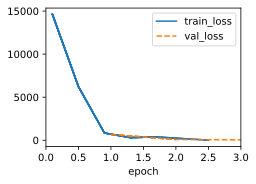

In [53]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        return torch.matmul(X.double(), self.w.double()) + self.b.double()

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)




class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()




model = LinearRegressionScratch(data_tensor.shape[1], lr=0.001)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, my_data)
